In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

#from sklearn.neighbors import KernelDensity
#from sklearn.model_selection import GridSearchCV
from util import util
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
#import pandas as pd

## Load data
#data_folder = '/app/data/nab'
#
#file_name1 = 'realTweets/Twitter_volume_AMZN.csv'
#data1, labels1, windows1 = nab.load_series(file_name1, data_folder)
#
#file_name2 = 'realTraffic/occupancy_6005.csv'
#data2, labels2, windows2 = nab.load_series(file_name2, data_folder)

# Load data
data_folder = os.path.join('..', 'data', 'nab')
file_name = os.path.join('realTraffic', 'occupancy_6005.csv')
data, labels, windows = util.load_series(file_name, data_folder)
ddata = data.resample('5min').mean()
ddata = ddata.loc['2015-09-15-06:00':'2015-09-15-23:00']

# Basic Approaches for Missing Values

## Basic Approaches for Missing Values

**We will now discuss a few simple approaches to deal with missing values**

We will use _partially synthetic data_

* We will focus on specific (and mosly intact) sections of our series
* The we will remove values artificially
* ...And measure the accuracy of our filling approaches via the Root MSE

$$
\mathit{RMSE} = \sqrt{\frac{1}{n}\sum_{i = 0}^n (x_i - \hat{x}_i)^2}
$$

Where $x_i$ is a value from the filled series and $\hat{x}_i$ the ground truth

* $x_i = \hat{x}_i$ if no value is missing
* Hence, any MSE difference is entirely due to missing values

## The Benchmark Dataset

**Our benchmark dataset will consist of this particular stretch from our traffic series**

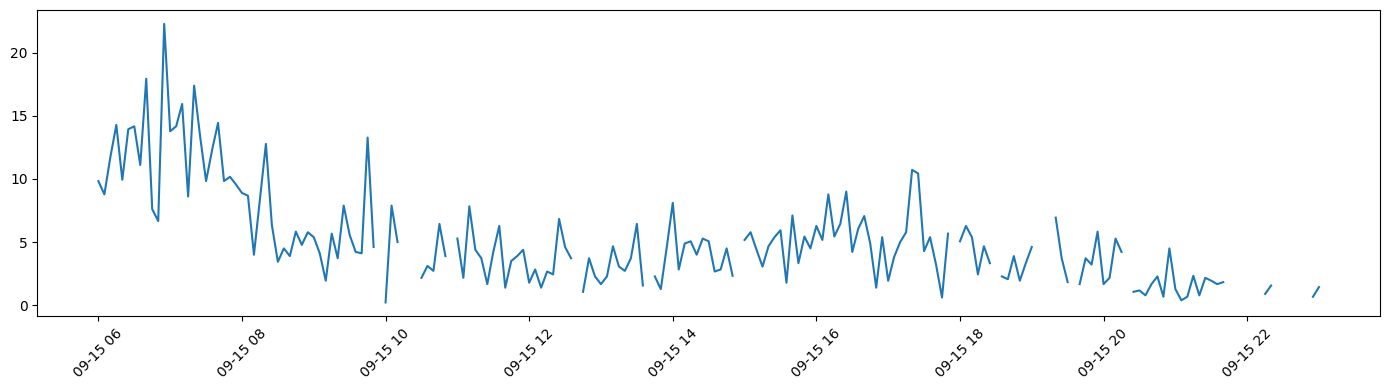

In [2]:
util.plot_series(ddata, figsize=figsize)

* There are (comparatively) few missing values
* Some of them are isolated, some for contiguous "holes"

## The Benchmark Dataset

**We now introduce some missing values**

...By drawing them at random:

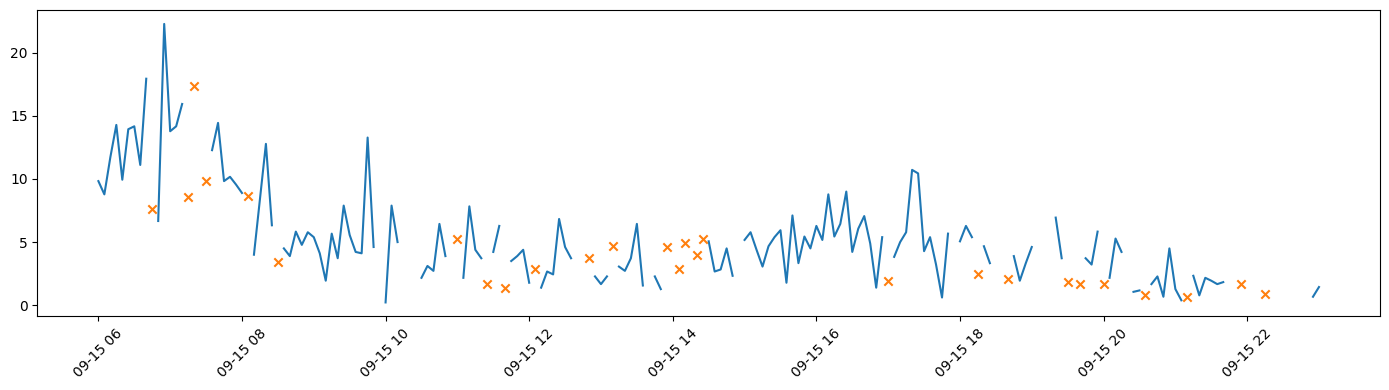

In [3]:
np.random.seed(42) # seed (to get reproducible results)
mv_idx = np.random.choice(range(len(ddata.index)), size=30, replace=False)
ddata_mv = ddata.copy()
ddata_mv.iloc[mv_idx] = np.NaN
util.plot_series(ddata_mv, figsize=figsize)
plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');

* The orange markers represent the value that have been removed

## Forward/Backward Filling

**The easiest approach for missing values consists in _replicating nearby observations_**

* _Forward filling:_ propagate forward the last valid observation
* _Backward filling:_ propagate backward the next valid observation

**An important observation:**

* When filling missing values, _we have access to the whole series_
* ...So we can reason _both forward and backward_

**Forward/backward filling are simple methods, but they can work well**

* Rationale: most time series have a certain "inertia"
* ...I.e.: a strong level of local correlation
* For this reason (e.g.) _the last observation is often a good predictor_ for the next one

## Forward/Backward Filling

**Forward and backward filling are pre-implemented in pandas**

They are available through the `fillna` method:

```python
DataFrame.fillna(..., method=None, ...)
```

* `fillna` replaces `NaN` values in a `DataFrame` or `Series`
* The `method` parameter can take the values:
  * "pad" or "ffill": these correspond to forward filling
  * "backfill" or "bfill": these correspond to backward filling

They are generally applied to datasets with a dense index

* Remember that our benchmark dataset already has a dense index

## Forward/Backward Filling on the Benchmark

**We can finally test forward/backward filling**

In [4]:
nan_mask = ddata['value'].isnull()
ffseries = ddata_mv.fillna(method='ffill')
ffseries[nan_mask] = np.NaN # We empty the values that were originally empty
bfseries = ddata_mv.fillna(method='bfill')
bfseries[nan_mask] = np.NaN # We empty the values that were originally empty

We can check the corresponding RMSE:

In [6]:
rmse_ff = np.sqrt(mean_squared_error(ddata[~nan_mask], ffseries[~nan_mask]))
rmse_bf = np.sqrt(mean_squared_error(ddata[~nan_mask], bfseries[~nan_mask]))
print(f'RMSE for forwad filling: {rmse_ff:.2f}, for backward filling {rmse_bf:.2f}')

RMSE for forwad filling: 1.33, for backward filling 0.87


* In this case backward filling seems to work better
* The results are of course application-dependent

## Forward/Backward Filling on the Benchmark

**Let's have a close look at the results for _forward filling_**

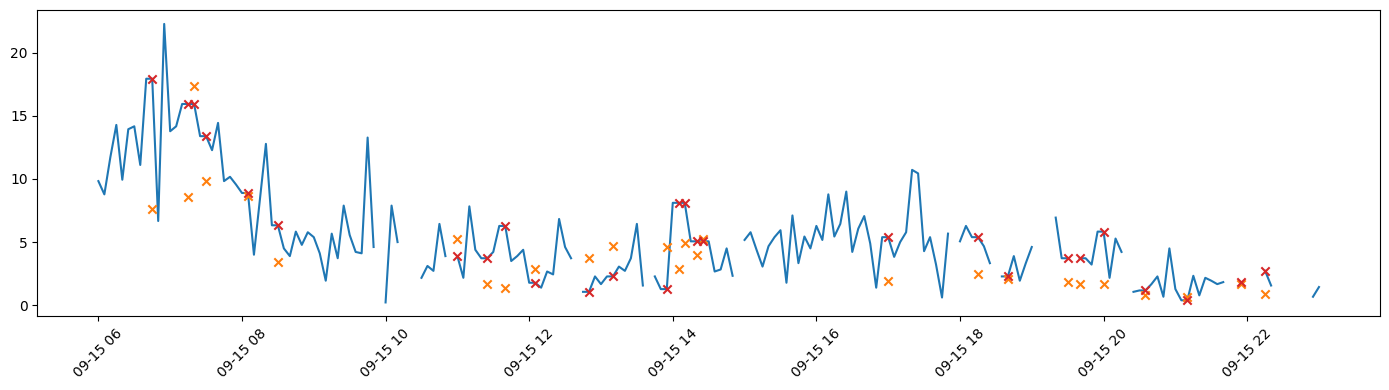

In [16]:
util.plot_series(ffseries, figsize=figsize)
plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');
plt.scatter(ddata.index[mv_idx], ffseries.iloc[mv_idx], color='tab:red', marker='x');

* The red marks represent the values that have been filled

## Forward/Backward Filling on the Benchmark

**Let's have a close look at the results for _backward filling_**

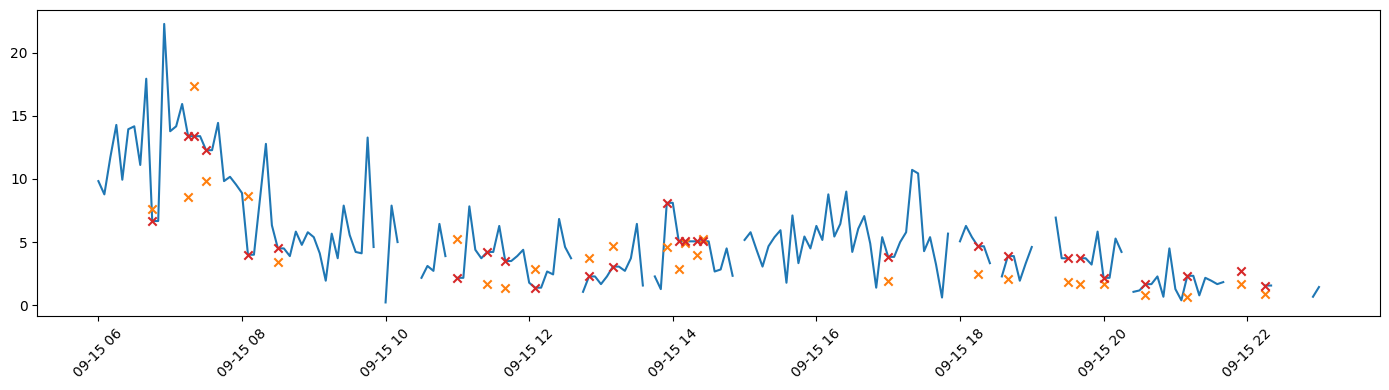

In [17]:
util.plot_series(bfseries, figsize=figsize)
plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');
plt.scatter(ddata.index[mv_idx], bfseries.iloc[mv_idx], color='tab:red', marker='x');

* Forward/backward filling tend to work well for _low variance_ sections
* ...And conversely work worse for _high variance_ sections

## (Geometric) Interpolation

**A few more options are available via [the `interpolate` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)**

```python
DataFrame/Series.interpolate(method='linear', ...)
```

The `method` parameter determines how NaNs are filled:

* "linear" uses a linear interpolation, assuming uniformly spaced samples
* "time" uses a linear interpolation, but supports non-uniformly spaced samples
* "nearest" uses the closest value
* "polynomial" uses a polynomial interpolation
* Even "ffill" and "bfill" are available

Both "polynomial" and "spline" require to specify the additional parameter `order`

* E.g. `df.interpolate(method='polynomial', order='3')`

## (Geometric) Interpolation

**Let us check the performance of some approaches**

In [45]:
args = [{'method':'linear'}, {'method':'time'}, {'method':'nearest'},
        {'method':'polynomial', 'order': 2}, {'method':'spline', 'order': 4}]
filling_res = {}
for a in args:
    filling_res[a['method']] = ddata_mv.interpolate(**a)
    rmse = np.sqrt(mean_squared_error(ddata[~nan_mask], filling_res[a['method']][~nan_mask]))
    print(f'RMSE for {a["method"]}: {rmse:.2f}')

RMSE for linear: 0.98
RMSE for time: 0.98
RMSE for nearest: 1.35
RMSE for polynomial: 1.10
RMSE for spline: 1.03


* "linear" and "time" are equivalent (we have uniformly-spaced samples)
* "polynomial" is the most complex, and in this case also the worst

All perform _worse_ than backward filling (at least in this case)!

## Linear Filling on the Benchmark

**Let's have a close look at the results for _linear filling_**

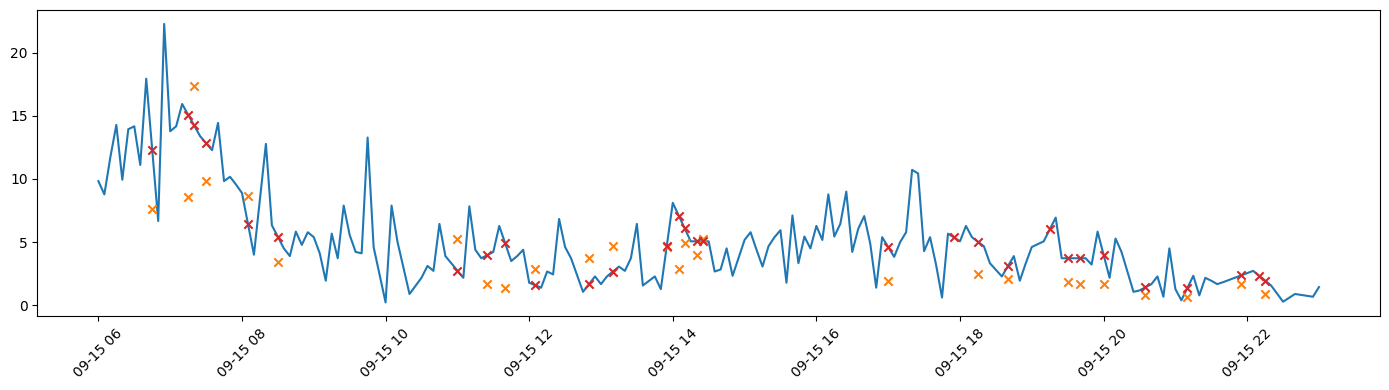

In [46]:
util.plot_series(filling_res['linear'], figsize=figsize)
plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');
plt.scatter(ddata.index[mv_idx], filling_res['linear'].iloc[mv_idx], color='tab:red', marker='x');

* Linear filling works well for series with _slower dynamics_ 
* ...But does not work well for series that _faster dynamics_

## Nearest Filling on the Benchmark

**Let's have a close look at the results for _nearest filling_**

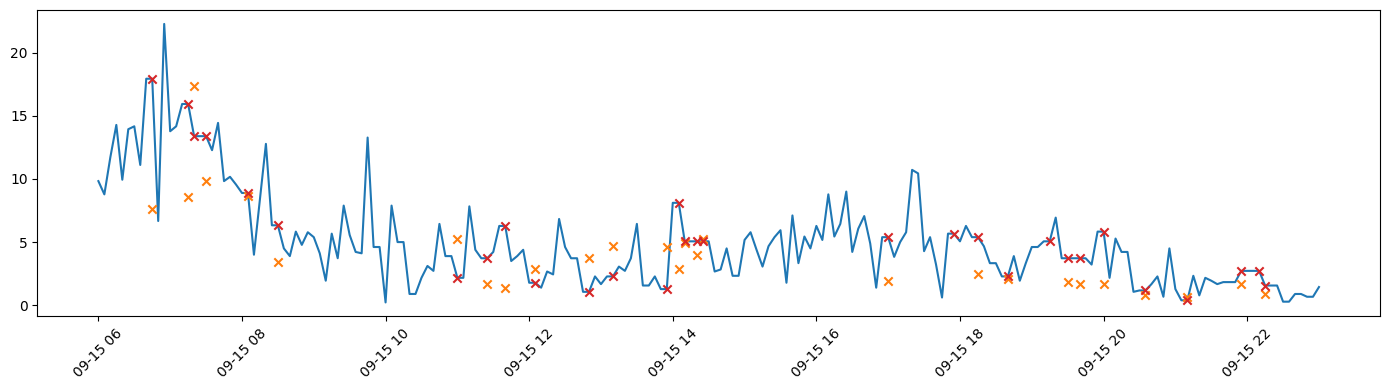

In [47]:
util.plot_series(filling_res['nearest'], figsize=figsize)
plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');
plt.scatter(ddata.index[mv_idx], filling_res['nearest'].iloc[mv_idx], color='tab:red', marker='x');

* Nearest filling is a _compromise between forward and backward filling_
* ...And in our case its performance is the average of the two

## Polynomial Filling on the Benchmark

**Let's have a close look at the results for _polynomial filling_**

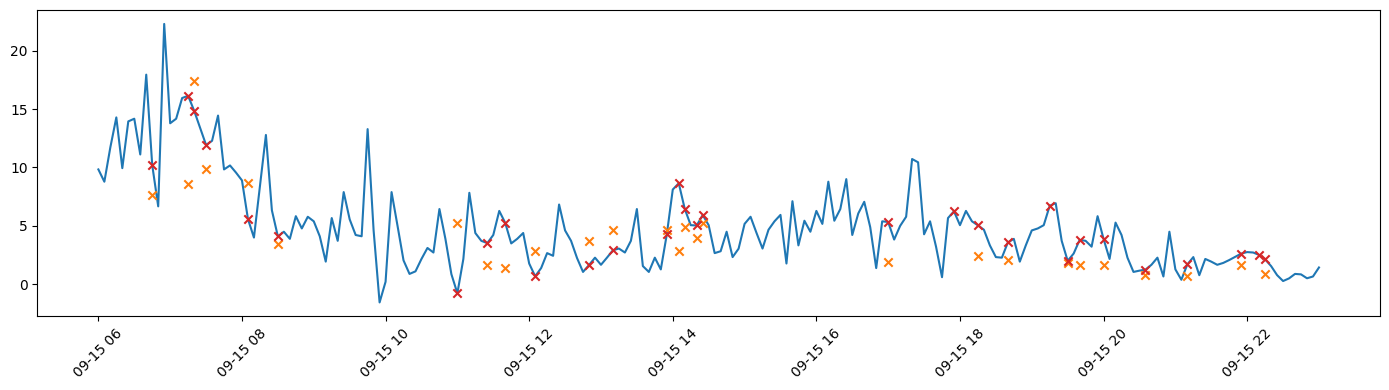

In [48]:
util.plot_series(filling_res['polynomial'], figsize=figsize)
plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');
plt.scatter(ddata.index[mv_idx], filling_res['polynomial'].iloc[mv_idx], color='tab:red', marker='x');

* Polynomial interpolation relies in nearby value to fit a polynomial
* _High-order polinomial often vary too much_ and work less well

## Spline Filling on the Benchmark

**Let's have a close look at the results for _spline filling_**

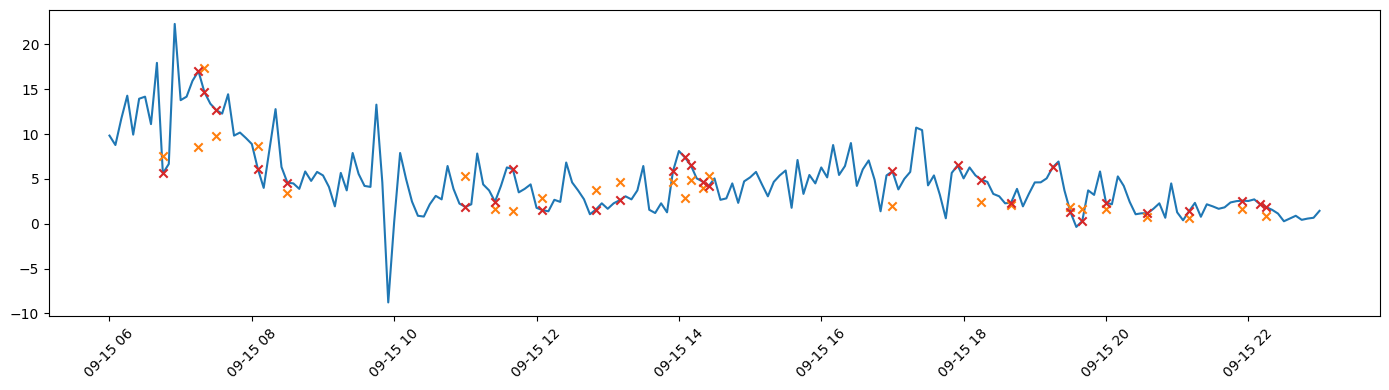

In [49]:
util.plot_series(filling_res['spline'], figsize=figsize)
plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');
plt.scatter(ddata.index[mv_idx], filling_res['spline'].iloc[mv_idx], color='tab:red', marker='x');

* Spline interpolation relies on [piecewise polynomial curves](https://en.wikipedia.org/wiki/Spline_(mathematics))
* ...And it's often _more robust than polynomial interpolation_

<div class=big>How do we choose which method is best? Is the (R)MSE enough?</div> 